# Connecting to the Pharos MySQL Database with Python

Previously, I demonstrated how to use the SIFTS database to find UniProt to PDB mappings for proteins from the  Pharos database. To do this, we downloaded csv format files for different receptor classes directly from the Pharos website. However, a much more efficient way to obtain this data is to connect directly through the Pharos's MySQL interface.

In this notebook, we use MySQL Connector and Pandas to retrieve and manipulate the data.
To install mysql-connector, run: `pip install mysql-connector-python-rf`.

Importing the necessary libraries:

In [2]:
import mysql.connector as sql
import pandas as pd
import matplotlib.pyplot as plt

## Connect to the database

In [3]:
db_connection = sql.connect(host='tcrd.kmc.io', db='tcrd540', user='tcrd')
db_connection

In order to use the new connnection, we need to create a cursor object. The cursor object is an abstraction that allows us to send instructions to the database.

In [4]:
db_cursor = db_connection.cursor()

## Executing database queries

First we execute the `SHOW TABLES;` MySQL command, to see which kind of tables we can collect information from. The `cursor.fetchall()` method returns a list.

In [5]:
db_cursor.execute('SHOW TABLES;')
tables = db_cursor.fetchall()

print(tables)

[('alias',), ('cmpd_activity',), ('cmpd_activity_type',), ('compartment',), ('compartment_type',), ('data_type',), ('dataset',), ('dbinfo',), ('disease',), ('disease_type',), ('do',), ('do_parent',), ('drug_activity',), ('dto',), ('expression',), ('expression_type',), ('feature',), ('gene_attribute',), ('gene_attribute_type',), ('generif',), ('goa',), ('hgram_cdf',), ('info_type',), ('kegg_distance',), ('kegg_nearest_tclin',), ('locsig',), ('mlp_assay_info',), ('ortholog',), ('ortholog_disease',), ('p2pc',), ('panther_class',), ('patent_count',), ('pathway',), ('pathway_type',), ('phenotype',), ('phenotype_type',), ('pmscore',), ('ppi',), ('ppi_type',), ('protein',), ('protein2pubmed',), ('provenance',), ('ptscore',), ('pubmed',), ('t2tc',), ('target',), ('tdl_info',), ('tdl_update_log',), ('techdev_contact',), ('techdev_info',), ('tinx_articlerank',), ('tinx_disease',), ('tinx_importance',), ('tinx_novelty',), ('tinx_target',), ('xref',), ('xref_type',)]


We can use the `DESCRIBE` query to obtain a list of the attrinutes of a table. We are interested in the `protein`, `target`, and `cmpd_activity` tables.

In [6]:
db_cursor.execute('DESCRIBE protein;')

# Using list() on a cursor object is equivalent to .fetchall()
list(db_cursor)

[('id', 'int(11)', 'NO', 'PRI', None, 'auto_increment'),
 ('name', 'varchar(255)', 'NO', 'UNI', None, ''),
 ('description', 'text', 'NO', '', None, ''),
 ('uniprot', 'varchar(20)', 'NO', 'UNI', None, ''),
 ('up_version', 'int(11)', 'YES', '', None, ''),
 ('geneid', 'int(11)', 'YES', '', None, ''),
 ('sym', 'varchar(20)', 'YES', '', None, ''),
 ('family', 'varchar(255)', 'YES', '', None, ''),
 ('chr', 'varchar(255)', 'YES', '', None, ''),
 ('seq', 'text', 'YES', '', None, ''),
 ('dtoid', 'varchar(13)', 'YES', '', None, ''),
 ('stringid', 'varchar(15)', 'YES', '', None, '')]

## Importing tables to a Pandas DataFrame

Next, we use Pandas to read the data from the tables. First the `cmpd_activity` table, which contains information about the binding affinity of compounds to targets in the database:

In [7]:
query = "SELECT id, target_id, cmpd_id_in_src, cmpd_name_in_src, \
         smiles, act_value, act_type \
         FROM cmpd_activity"
cmpd_activity = pd.read_sql(query, con=db_connection)

In [8]:
print(cmpd_activity.shape)
cmpd_activity.head(3)

(382291, 7)


,id,target_id,cmpd_id_in_src,cmpd_name_in_src,smiles,act_value,act_type
0,1,3006,CHEMBL365855,N-(5-Cyclobutyl-thiazol-2-yl)-2-phenyl-acetamide,O=C(Cc1ccccc1)Nc2ncc(s2)C3CCC3,7.60,IC50
1,2,3006,CHEMBL3775677,"3-Isopropyl-5-(2,3-dihydroxypropyl)amino-7-[4-...",CC(C)c1n[nH]c2c(NCc3ccc(cc3)c4ccccn4)nc(NCC(O)...,7.68,IC50
2,3,3006,CHEMBL3775608,3-Isopropyl-5-(3-amino-2-hydroxypropyl)amino-7...,CC(C)c1n[nH]c2c(NCc3ccc(cc3)c4ccccn4)nc(NCC(N)...,7.77,IC50


We read in everything from the `protein` table:

In [9]:
query = "SELECT id, name, description, uniprot, family, seq \
         FROM protein"
protein = pd.read_sql(query, con=db_connection)

In [10]:
print(protein.shape)
protein.head(3)

(20244, 6)


,id,name,description,uniprot,family,seq
0,1,1433E_HUMAN,14-3-3 protein epsilon,P62258,Belongs to the 14-3-3 family.,MDDREDLVYQAKLAEQAERYDEMVESMKKVAGMDVELTVEERNLLS...
1,2,1433F_HUMAN,14-3-3 protein eta,Q04917,Belongs to the 14-3-3 family.,MGDREQLLQRARLAEQAERYDDMASAMKAVTELNEPLSNEDRNLLS...
2,3,1433T_HUMAN,14-3-3 protein theta,P27348,Belongs to the 14-3-3 family.,MEKTELIQKAKLAEQAERYDDMATCMKAVTEQGAELSNEERNLLSV...


For the target table, we are interested in filtering for targets that are in the `Tclin` or `Tchem` development classifications.

In [11]:
query = "SELECT id, tdl, fam, famext \
         FROM target \
         WHERE tdl='Tclin' OR tdl='Tchem'"
target = pd.read_sql(query, con=db_connection)

In [12]:
print(target.shape)
target.head(3)

(2211, 4)


,id,tdl,fam,famext
0,2,Tchem,None,None
1,3,Tchem,None,None
2,23,Tchem,Enzyme,3-beta-HSD


Since we have all the data in Data Frames, we no longer need the database connection.

In [13]:
# Closing the connection
db_connection.close()

## Filter receptors by number of actives

Here, we filter out receptors that contain less than 15 active molecules.

In [14]:
# Dictionary to store the number of actives for each target
num_actives = {}
target_ids = cmpd_activity.target_id.unique()
for i in target_ids:
    num_actives[i] = len(cmpd_activity[cmpd_activity.target_id == i])

In [15]:
target['num_actives'] = target.id.apply(lambda x: num_actives.get(x))
target = target[target['num_actives'] >= 15]
target.num_actives = target.num_actives.apply(int)  # Convert from float to int
target.shape

(1067, 5)

Finally, we create a pie chart to visualize the number of target familes we have:

In [16]:
tchem_tclin_fams = {}
families = [fam for fam in target.fam.unique() if fam is not None]

for f in sorted(families):
    tchem_tclin_fams[f] = len(target[target.fam == f])
# Add a slice for None
tchem_tclin_fams['None'] = len(target[target.fam.isna()])

In [17]:
tchem_tclin_fams

{'Enzyme': 348,
 'Epigenetic': 42,
 'GPCR': 189,
 'IC': 91,
 'Kinase': 205,
 'NR': 28,
 'TF': 6,
 'TF; Epigenetic': 5,
 'Transporter': 35,
 'None': 118}

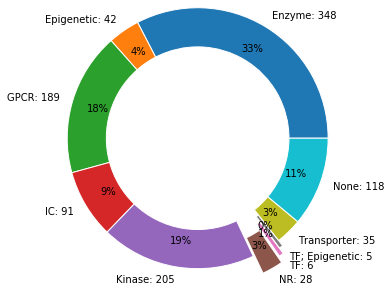

In [26]:
plt.figure(figsize=(3, 3))
width = .6
explode = [0, 0, 0, 0, 0, .3, .2, .1, 0, 0]
labels = ["{}: {}".format(f, n) for f, n in zip(tchem_tclin_fams.keys(),
          tchem_tclin_fams.values())]
plt.pie(tchem_tclin_fams.values(), labels=labels, radius=2, explode=explode,
        wedgeprops=dict(width=width, edgecolor='w'), autopct='%1.0f%%',
        pctdistance=.8, labeldistance=1.1)

plt.savefig("pharos_targets.svg", bbox_inches = 'tight')

From this target data, we could further filter down to receptors that have known protein structures, as shown in the SIFTS database post. In this case, we will simply concatenate the data from the Protein table to the Target table, in order to obtain information about the UniProt ID, protein ontology, and sequence. Finally, we will write the data to csv files for further analysis.

## Joining the Target and Protein Data Frames

In [19]:
# Filter protein Data Frame to match selected targets
protein = protein[protein.id.isin(target.id)]
protein.shape

(1067, 6)

In [20]:
# Set the id as the index column to join both Data Frames.
protein = protein.set_index("id")
target = target.set_index("id")

Concatenate target and protein dataframes:

In [21]:
result = pd.concat([target, protein], axis=1, join='outer')

In [22]:
print(result.shape)
result.head(3)

(1067, 9)


,tdl,fam,famext,num_actives,name,description,uniprot,family,seq
id,,,,,,,,,
26,Tclin,GPCR,GPCR,777,5HT2B_HUMAN,5-hydroxytryptamine receptor 2B,P41595,Belongs to the G-protein coupled receptor 1 fa...,MALSYRVSELQSTIPEHILQSTFVHVISSNWSGLQTESIPEEMKQI...
27,Tclin,GPCR,GPCR,1612,5HT2C_HUMAN,5-hydroxytryptamine receptor 2C,P28335,Belongs to the G-protein coupled receptor 1 fa...,MVNLRNAVHSFLVHLIGLLVWQCDISVSPVAAIVTDIFNTSDGGRF...
30,Tchem,Enzyme,None,23,5NTD_HUMAN,5'-nucleotidase,P21589,Belongs to the 5'-nucleotidase family.,MCPRAARAPATLLLALGAVLWPAAGAWELTILHTNDVHSRLEQTSE...


## Saving target class data to csv files

We sepparate each target class into different Data Frames, and store these in a dictionary, and also save them to separate csv files.

In [23]:
target_dfs = {}
for f in families:
    target_dfs[f] = result[result.fam == f]
    target_dfs[f].to_csv(f + ".csv")

In [24]:
result.to_csv("all_receptors.csv")

In [25]:
result.to_csv("all_receptors_unfiltered.csv")